# Analyse des sessions

On va s'intéresser dans cette section à l'historique des activités (sessions) des utilisateurs. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
users = pd.read_csv('data/train_users_2.csv')
test_users = pd.read_csv('data/test_users.csv')
sessions = pd.read_csv('data/sessions.csv')

users['found_destination'] = users.apply(lambda r: 'DF' if r['country_destination'] != 'NDF' else 'NDF', axis=1)

On a vu, dans l'introduction, qu'on ne dispose pas des sessions de tous les utilisateurs. De ce fait, on va sélectioner les utilisateurs qui ont une session avant d'équilibrer les classes (DF/NDF).

In [3]:
# Extract user ids who have sessions
base_user_ids = sessions['user_id'].unique()
base_user_ids = base_user_ids.tolist()
base_user_ids.remove(np.nan)

# Remove user ids who are from the test set
test_user_ids = test_users['id'].values
base_user_ids = list(set(base_user_ids) - set(test_user_ids))

# Select sessions with the remaining ids
users_by_ids = users.set_index('id')
session_users = users_by_ids.loc[base_user_ids]

# Balance DF and NDF labels
session_users_ndf = session_users[session_users['found_destination'] == 'NDF'].head(20000)
session_users_df = session_users[session_users['found_destination'] == 'DF'].head(20000)
session_users = pd.concat([session_users_ndf, session_users_df])

sessions = sessions[sessions['user_id'].isin(session_users.index)]
print(f'sessions.shape : {sessions.shape}')
sessions.head()

sessions.shape : (3088590, 6)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
127,yo8nz8bqcq,dashboard,view,dashboard,Mac Desktop,2739.0
128,yo8nz8bqcq,create,submit,create_user,Mac Desktop,NaN
129,yo8nz8bqcq,confirm_email,click,confirm_email_link,Mac Desktop,115983.0
130,yo8nz8bqcq,show,view,p3,Mac Desktop,20285.0
131,yo8nz8bqcq,show_personalize,data,user_profile_content_update,Mac Desktop,3255.0


On a 28000 utilisateurs DF et NDF.

In [4]:
sessions['found_destination'] = sessions.apply(lambda r: session_users.loc[r['user_id'], 'found_destination'], axis=1)

Median NDF : 191.36375 h
Median DF : 332.45944444444444 h


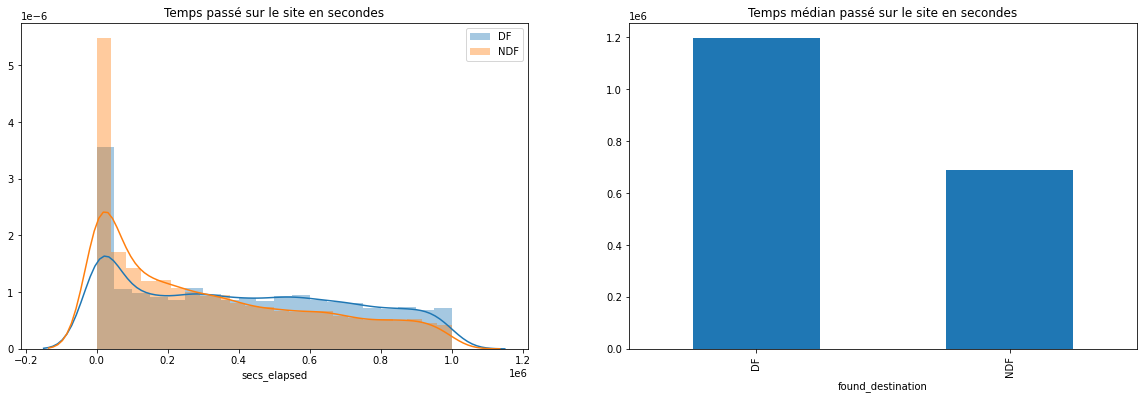

In [5]:
time_elapsed = sessions.groupby(['user_id', 'found_destination'])['secs_elapsed'].sum()
# sns.distplot(time_elapsed)
f = plt.figure(figsize=(20, 6))
f.add_subplot(1, 2, 1)
sns.distplot(time_elapsed[time_elapsed < 0.1e7].loc[:,'DF'], label='DF')
sns.distplot(time_elapsed[time_elapsed < 0.1e7].loc[:,'NDF'], label='NDF')
plt.title("Temps passé sur le site en secondes")
plt.legend()
print(f'Median NDF : {time_elapsed.loc[:, "NDF"].median() / (60**2)} h')
print(f'Median DF : {time_elapsed.loc[:, "DF"].median() / (60**2)} h')

f.add_subplot(1, 2, 2)
time_elapsed.groupby('found_destination').median().plot(kind='bar')
_ = plt.title("Temps médian passé sur le site en secondes")

Les DF passent beaucoup plus de temps sur le site que les NDF, probablement car ils font l'effort de renseigner leur profil, passer du temps sur les différentes annonces, écrire aux hôtes pour poser des questions, etc. Il est possible qu'une partie des NDF ne font que regarder, mais ce ne sont que des hypothèses.

On va récupérer les actions les plus présentes chez les DF puis chez les NDF.

In [6]:
# Actions that are common among DF / NDF
actions = sessions.groupby(['user_id', 'found_destination']).agg({'action': pd.Series.tolist}).reset_index()
actions['number_actions'] = actions.apply(lambda r: r['action'].__len__(), axis=1)
actions.head()

,user_id,found_destination,action,number_actions
0,00023iyk9l,DF,"[index, dashboard, header_userpic, dashboard, ...",40
1,0028jgx1x1,NDF,"[show, reviews, show, search, show, search, re...",31
2,002qnbzfs5,DF,"[social_connections, payment_methods, create, ...",789
3,0035hobuyj,DF,"[lookup, search_results, lookup, search_result...",489
4,003iamz20l,NDF,"[active, search, search, search, social_connec...",163


In [8]:
def count_actions(action, booked):
    actions['tmp'] = actions.apply(lambda r: 1 if action in r['action'] else 0, axis=1)
    res = actions[actions['found_destination'] == booked]['tmp'].sum()
    actions.drop('tmp', axis=1)
    return res

# Actions that are the most common among DF
action_stats_df = pd.DataFrame()
action_stats_df['action'] = sessions.action.unique()
action_stats_df['count'] = action_stats_df.apply(lambda r: count_actions(r['action'], 'DF'), axis=1)

# Actions that are the most common among NDF
action_stats_ndf = pd.DataFrame()
action_stats_ndf['action'] = sessions.action.unique()
action_stats_ndf['count'] = action_stats_ndf.apply(lambda r: count_actions(r['action'], 'NDF'), axis=1)

# Combine DF and NDF
action_stats = pd.DataFrame()
action_stats['action'] = sessions['action'].unique()
action_stats['count_df'] = action_stats_df['count'].values
action_stats['count_ndf'] = action_stats_ndf['count'].values
action_stats['diff'] = (action_stats['count_df'] - action_stats['count_ndf']) / (action_stats['count_df'] + action_stats['count_ndf'])

In [17]:
action_stats[action_stats['count_df'] + action_stats['count_ndf'] > 500].sort_values(by='diff').head(10)

,action,count_df,count_ndf,diff
73,set_user,525,1467,-0.472892
74,manage_listing,538,1493,-0.470212
46,domains,256,445,-0.269615
37,campaigns,2505,4223,-0.255351
48,search,2295,3817,-0.249018
34,collections,1319,2142,-0.237793
204,recommendations,205,331,-0.235075
31,social_connections,2053,3200,-0.218351
64,reviews,1917,2931,-0.209158
30,active,4619,6461,-0.166245


In [10]:
action_stats[action_stats['count_df'] + action_stats['count_ndf'] > 500].sort_values(by='diff').tail(10).sort_values(by='diff', ascending=False)

,action,count_df,count_ndf,diff
49,requested,4359,377,0.840794
50,pending,4848,504,0.811659
282,agree_terms_check,924,139,0.738476
281,message_to_host_change,788,132,0.713043
103,qt_with,469,91,0.675000
279,message_to_host_focus,832,163,0.672362
66,at_checkpoint,1378,287,0.655255
152,complete_redirect,910,207,0.629364
97,ajax_photo_widget_form_iframe,1104,258,0.621145
39,complete_status,1991,495,0.601770


In [18]:
sessions[sessions['action'] == 'reviews']

,user_id,action,action_type,action_detail,device_type,secs_elapsed,found_destination
2906,toga865pvz,reviews,-unknown-,-unknown-,-unknown-,473.0,NDF
2911,toga865pvz,reviews,-unknown-,-unknown-,iPhone,388.0,NDF
2912,toga865pvz,reviews,-unknown-,-unknown-,iPhone,48.0,NDF
2978,toga865pvz,reviews,-unknown-,-unknown-,iPhone,180.0,NDF
2988,toga865pvz,reviews,-unknown-,-unknown-,iPhone,3108.0,NDF
...,...,...,...,...,...,...,...
5555206,jh95kwisub,reviews,data,listing_reviews,iPhone,156.0,NDF
5555210,jh95kwisub,reviews,data,listing_reviews,iPhone,91.0,NDF
5555226,jh95kwisub,reviews,data,listing_reviews,iPhone,7502.0,NDF
5555241,nw9fwlyb5f,reviews,data,listing_reviews,iPhone,8.0,NDF
